# Section of region of interest

Load the file at a low resolution and add regions of interest.

In [58]:
import yaml
from pathlib import Path
from ipyfilechooser import FileChooser
srcdir, dstdir = '', ''
with open("config.yml", "r") as file:    
    config = yaml.safe_load(file)
    if 'source' in config.keys():
        srcdir = Path(config["source"])        
    if 'destination' in config.keys():
        dstdir = Path(config["destination"]) 

fc = FileChooser(dstdir, select_desc='destination')
display(fc)



FileChooser(path='/home/jeromeb/work/code/octopus/results', filename='', title='', show_hidden=False, select_d…

In [59]:
import pandas as pd
dstdir = Path(fc.selected) if fc.selected is not None else Path(dstdir)
filelistname = dstdir / 'filelist.csv'
filelist = pd.read_csv(filelistname)
filelist

,Unnamed: 0,folder,name
0,0,"/run/user/1000/gvfs/smb-share:server=cephfs2,s...",2023_13Dec_4a17Dec_F2_Stitched_Cropped_ForAnal...
1,1,"/run/user/1000/gvfs/smb-share:server=cephfs2,s...",2023_12Dec_2a17Dec_F2_Stitched_Cropped_ForAnal...
2,2,"/run/user/1000/gvfs/smb-share:server=cephfs2,s...",2023_20Dec_2aBatch2_12Dec_F1_Stitched_Cropped_...
3,3,"/run/user/1000/gvfs/smb-share:server=cephfs2,s...",14Aug2023_3b_Slices_F1_Stitched_Cropped_ForAna...


In [60]:
import ipywidgets as widgets
w = widgets.Dropdown(
    options=[(x,k) for k,x in enumerate(filelist['name'])],
    value=1,
    description='Image:',
)
display(w)

Dropdown(description='Image:', index=1, options=(('2023_13Dec_4a17Dec_F2_Stitched_Cropped_ForAnalysis.ims', 0)…

In [62]:
def get_files(dstdir, row, key=None):
    if key == 'ims':
        return Path(row['folder']) / row['name']
    elif key == 'regions':
        return Path(dstdir / str(row["name"]).replace('.ims','-regions.json'))
    elif key == 'labels':
        return Path(dstdir / str(row['name']).replace('.ims','-labels.tif'))
    elif key == 'measurements':
        return Path(dstdir / str(row['name']).replace('.ims','-measurements.csv'))    
    else:
        return {
            'ims': get_files(dstdir, row, 'ims'),
            'regions': get_files(dstdir, row, 'regions'),
            'labels': get_files(dstdir, row, 'labels'),
            'measurements':  get_files(dstdir, row, 'measurements')
        }
row = filelist.iloc[w.value]
filename = get_files(dstdir, row, 'ims')
regionname = get_files(dstdir, row, 'regions')
print("Input IMS filename:", filename)
print("Destination:", dstdir)
print("Output region file:", regionname)
cnf = yaml.safe_load(f'source: \"{srcdir}\"\ndestination: \"{dstdir}\"\n')
# update yaml config file
with open('config.yml', 'w') as file:
    yaml.dump(cnf, file)

Input IMS filename: /run/user/1000/gvfs/smb-share:server=cephfs2,share=users/acourtney/HCR_Octopus_Jerome/Febuary2024/2023_12Dec_2a17Dec_F2_Stitched_Cropped_ForAnalysis.ims
Destination: /home/jeromeb/work/code/octopus/results
Output region file: /home/jeromeb/work/code/octopus/results/2023_12Dec_2a17Dec_F2_Stitched_Cropped_ForAnalysis-regions.json


Load the file from disk

In [63]:
from imaris_ims_file_reader.ims import ims
import dask.array as da

resolution_level = 4

store = ims(filename, ResolutionLevelLock=resolution_level, aszarr=True)

img = da.from_zarr(store)
nuclei = da.max(img[0,3],0).compute().squeeze()

Opening readonly file: /run/user/1000/gvfs/smb-share:server=cephfs2,share=users/acourtney/HCR_Octopus_Jerome/Febuary2024/2023_12Dec_2a17Dec_F2_Stitched_Cropped_ForAnalysis.ims 

GET : .zarray
GET : 0.3.0.0.0
[(0, 1), (3, 4), (0, 21), (0, 128), (0, 128)]
GET : 0.3.0.0.1
[(0, 1), (3, 4), (0, 21), (0, 128), (128, 143)]
GET : 0.3.0.1.0
[(0, 1), (3, 4), (0, 21), (128, 240), (0, 128)]
GET : 0.3.0.1.1
[(0, 1), (3, 4), (0, 21), (128, 240), (128, 143)]
(1, 1, 21, 128, 15)
(1, 1, 21, 112, 128)
(1, 1, 21, 128, 128)
(1, 1, 21, 112, 15)


Load the file in napari and add some regions. If there are existing regions, load the regions as shapes.

In [66]:
import json
import numpy as np
import napari

v = napari.view_image(nuclei)
if regionname.exists():
    with open(regionname, "r") as outfile:
        poly = json.load(outfile)
    c = resolution_level / poly['resolution_level']    
    sdata = [c * np.array(p) for p in poly['regions']]
    v.add_shapes(poly['regions'],shape_type='polygon')


Closing file: /run/user/1000/gvfs/smb-share:server=cephfs2,share=users/acourtney/HCR_Octopus_Jerome/Febuary2024/2023_12Dec_2a17Dec_F2_Stitched_Cropped_ForAnalysis.ims 



Export the region to a json file

In [67]:
import json
poly = {
    'shape': nuclei.shape,
    'resolution_level': resolution_level,
    'regions': [ p.tolist() for p in v.layers[-1].data ] 
}

with open(regionname, "w") as outfile:
    json.dump(poly, outfile)

Reload the regions

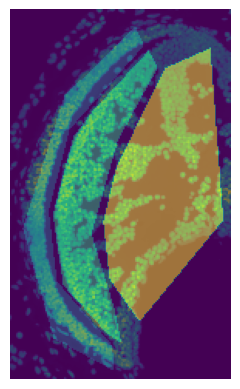

In [70]:
import matplotlib.pyplot as plt

with open(regionname, "r") as outfile:
    poly2 = json.load(outfile)

rois = napari.layers.Shapes(poly2['regions'],shape_type='polygon').to_labels(labels_shape=poly2['shape'])
plt.imshow(nuclei)
plt.imshow(rois,alpha=0.5)
plt.axis('off');